<a href="https://colab.research.google.com/github/akirakudo901/MyFirstCNN/blob/master/MyFirstCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Here is my attempt as of 2023/05/01 to understand how CNNs work.**

To grasp how to create & train a CNN, I use the [KMNIST dataset](https://github.com/rois-codh/kmnist)
, defining my own models until a CNN emerges with good enough
performance.

(Apparently an above 97% accuracy is a good goal, since benchmarks perform at 99% and above, while my initial trial yielded 94%.)


Below will also be the general idea for my coding journey.

**Task definition**

Our goal is to create a CNN which takes in KMNIST images and classifies the label of 
those images with some accuracy.

Supervised learning on images.
- Dataset: KMNIST dataset, 10 classes of 7000 images each.
- Input: 3x28x28 image.
- Output: probability that the image is in one of the 10 categories.

**Rough flow of work**

- Divide data into training and testing (as given, 6:1. Could also make a "validation" dataset, but task might be simple enough to ignore this).
- Define a CNN model. This should be the most learning-ful part.
- Training:
1. Initialize the model
2. Feed images as batch into the network to calculate predictions
3. Obtain the loss by comparing with the actual labels
4. Model learns via parameter adjustment with loss
5. The capability to generalize is monitored via loss calculated upon the testing set
6. Process repeated until training loss goes down and testing loss stays low
7. *Evaluate the ultimate capability through loss onto validation set (If I want to).*

To be iterated over different hyperparameters (epoch, learning rate, etc.)

***Credits:***

The dataset and work related is attributed as below:

"KMNIST Dataset" (created by CODH), adapted from "Kuzushiji Dataset" (created by NIJL and others), doi:10.20676/00000341

In [ ]:
# Some setup code for folders
!mkdir kmnist
!mkdir models

data_download_folder = "./kmnist"

#**Visualization of data**

In [ ]:
# Data download
# Code adapted from interactive download python code in kmnist github repo.
import requests

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')



# Download a list of files
def download_list(url_list, save_folder_path):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(save_folder_path + "/" + path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# download Kuzushiji-MNIST (10 classes, 28x28, 70k examples) in NumPy data format (.npz)
download_list(['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
              'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
              'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
              'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
              data_download_folder)

100%|██████████| 17954/17954 [00:04<00:00, 4203.34KB/s]


100%|██████████| 30/30 [00:00<00:00, 858.66KB/s]


100%|██████████| 3008/3008 [00:01<00:00, 2851.66KB/s]


100%|██████████| 6/6 [00:00<00:00, 11915.64KB/s]

All dataset files downloaded!


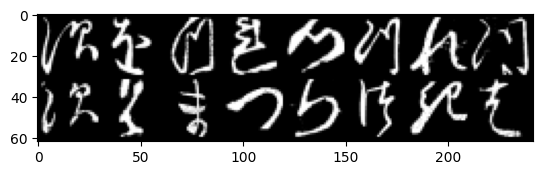

In [ ]:
# Show some images from the source
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt

with np.load(data_download_folder + "/" + "kmnist-test-imgs.npz") as data:
    test_imgs = torch.from_numpy(data["arr_0"][:16]).unsqueeze(1)
    plt.imshow(
        np.transpose(
            torchvision.utils.make_grid(test_imgs).numpy(), 
            (1, 2, 0)
            ),
        cmap='gray', 
        vmin=0, 
        vmax=255
        )
        
    plt.show()

# **MyCNN code**

In [ ]:
"""
Code implementing my own CNN. Start from a very basic understanding, and then build 
and experiment to see what's gonna succeed in performing well.

I might use the article below as learning source for implementing "LeNet".
https://pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class MyFirstCNNv1(nn.Module):

    def __init__(self, 
                 input_shape : tuple[int, int, int],
                 output_size : int
                 ):
        """
        Creates a CNN with convolution - max pool stacks.
        First version implemented, which scored an accuracy of nearly 95%. 

        :param Tuple input_size: A tuple (channel, height, width) for input shape of image.
        :param int output_size: The size of output equal to the number of classes we predict for.
        """
        super(MyFirstCNNv1, self).__init__()

        num_channel = input_shape[0]
        l1_num_kernel = 32
        l2_num_kernel = l1_num_kernel * 2
        
        self.conv_mpool_stack = nn.Sequential(
            nn.Conv2d( #28x28x3 -> 24x24x32
                in_channels=num_channel,
                out_channels=l1_num_kernel,
                kernel_size=5
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #24x24x32 -> 12x12x32
            nn.Conv2d(l1_num_kernel, l2_num_kernel, 3), #12x12x32 -> 10x10x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) #10x10x64 -> 5x5x64
        )
        #fully connected layers
        fc1_in = 5**2 * l2_num_kernel
        fc1_out = fc1_in * 2
        fc2_in = fc1_out

        self.fc1 = nn.Linear( #fc1_in -> fc2_in
            in_features= fc1_in,
            out_features= fc1_out
        )
        self.fc2 = nn.Linear(fc2_in, output_size) #fc2_in -> 10
    
    def forward(self, x : torch.tensor):
        """
        Evaluates the given tensor in this model.

        :param torch.tensor x: The given tensor of shape (batch, channel, height, width).
        :return torch.tensor: The evaluated tensor to be returned.
        """
        x = self.conv_mpool_stack(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x


class MyFirstCNNv2(nn.Module):

    def __init__(self, 
                 input_shape : tuple[int, int, int],
                 output_size : int
                 ):
        """
        Creates a CNN with convolution - max pool stacks.
        Second version with the goal to increase the number of conv layers by 1.

        :param Tuple input_size: A tuple (channel, height, width) for input shape of image.
        :param int output_size: The size of output equal to the number of classes we predict for.
        """
        super(MyFirstCNNv2, self).__init__()

        num_channel = input_shape[0]
        l1_num_kernel = 32
        l2_num_kernel = l1_num_kernel * 2
        l3_num_kernel = l2_num_kernel * 2

        self.conv_mpool_stack = nn.Sequential(
            nn.Conv2d( #28x28x3 -> 28x28x32
                in_channels=num_channel,
                out_channels=l1_num_kernel,
                kernel_size=5,
                padding='same'
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #28x28x32 -> 14x14x32
            nn.Conv2d(l1_num_kernel, l2_num_kernel, 3, padding='same'), #14x14x32 -> 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #14x14x64 -> 7x7x64
            nn.Conv2d(l2_num_kernel, l3_num_kernel, 3, padding='same'), #7x7x64 -> 7x7x128
            nn.ReLU()
            # nn.AvgPool2d(kernel_size=7) #7x7x128 -> 1x1x128
        )
        #fully connected layers
        fc1_in = 7**2 * l3_num_kernel
        fc1_out = fc1_in * 2
        fc2_in = fc1_out

        self.fc1 = nn.Linear( #fc1_in -> fc2_in
            in_features= fc1_in,
            out_features= fc1_out
        )
        self.fc2 = nn.Linear(fc2_in, output_size) #fc2_in -> 10
    
    def forward(self, x : torch.tensor):
        """
        Evaluates the given tensor in this model.

        :param torch.tensor x: The given tensor of shape (batch, channel, height, width).
        :return torch.tensor: The evaluated tensor to be returned.
        """
        x = self.conv_mpool_stack(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

class MyFirstCNNv3(nn.Module):

    def __init__(self, 
                 input_shape : tuple[int, int, int],
                 output_size : int
                 ):
        """
        Creates a CNN with convolution - max pool stacks.
        Third version with the goal to combine two types of conv layers together from v1 and v2
        for different field of vision.

        :param Tuple input_size: A tuple (channel, height, width) for input shape of image.
        :param int output_size: The size of output equal to the number of classes we predict for.
        """
        super(MyFirstCNNv3, self).__init__()

        num_channel = input_shape[0]
        l1_num_kernel = 32 # keeping # of kernels the same, twice as expensive to compute 
        l2_num_kernel = l1_num_kernel * 2
        l3_num_kernel = l2_num_kernel * 2
        
        # conv stack 1, taken from v1
        self.conv_mpool_stack_1 = nn.Sequential(
            nn.Conv2d( #28x28x3 -> 24x24x32
                in_channels=num_channel,
                out_channels=l1_num_kernel,
                kernel_size=5
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #24x24x32 -> 12x12x32
            nn.Conv2d(l1_num_kernel, l2_num_kernel, 3), #12x12x32 -> 10x10x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) #10x10x64 -> 5x5x64
        )
        # conv stack 2, taken from v2
        self.conv_mpool_stack_2 = nn.Sequential(
            nn.Conv2d( #28x28x3 -> 28x28x32
                in_channels=num_channel,
                out_channels=l1_num_kernel,
                kernel_size=5,
                padding='same'
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #28x28x32 -> 14x14x32
            nn.Conv2d(l1_num_kernel, l2_num_kernel, 3, padding='same'), #14x14x32 -> 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #14x14x64 -> 7x7x64
            nn.Conv2d(l2_num_kernel, l3_num_kernel, 3, padding='same'), #7x7x64 -> 7x7x128
            nn.ReLU()
        )
        #fully connected layers
        fc1_in = (5**2 * l2_num_kernel) + (7**2 * l3_num_kernel)
        fc1_out = fc1_in * 2
        fc2_in = fc1_out

        self.fc1 = nn.Linear( #fc1_in -> fc2_in
            in_features= fc1_in,
            out_features= fc1_out
        )
        self.fc2 = nn.Linear(fc2_in, output_size) #fc2_in -> 10
    
    def forward(self, x : torch.tensor):
        """
        Evaluates the given tensor in this model.

        :param torch.tensor x: The given tensor of shape (batch, channel, height, width).
        :return torch.tensor: The evaluated tensor to be returned.
        """
        x1 = self.conv_mpool_stack_1(x)
        x2 = self.conv_mpool_stack_2(x)
        x = torch.cat( (torch.flatten(x1, start_dim=1), torch.flatten(x2, start_dim=1)), dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

#**Training**

In [ ]:
"""
The code to be ultimately ran to execute training of our neural network.
The rough sketch is given in the "rough flow of work" part in the README.
"""

from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

#TODO MAKE INTO AN ACTUAL EXPLANATION OF THE CODE
# TAKES A MODEL, AN OPTIMIZER, THE TRAIN / TEST DATA, THE NUMBER OF EPOCHS, 
# BATCH SIZE AND LEARNING RATE TO TRAIN THE MODEL AND RETURN A TRAINED VERSION 
# COULD INCLUDE OPTIMIZERS AND LOSS FUNCTIONS AS VARIABLES IF I REALLY WANTED TO
def train(model : nn.Module, 
          train_data : Dataset, 
          test_data : Dataset,
          num_classes : int,
          num_epochs : int,
          batch_size : int, 
          learning_rate : float,
          device
          ):
    
    # Initialization
    # first create dataloaders containing the data such that we can iterate on
    train_dloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_dloader = DataLoader(dataset=test_data, batch_size=batch_size)
    
    # set the loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

    # store training / testing accuracy and loss over time
    train_acc, test_acc, train_loss, test_loss = [], [], [], []


    # Train loop per epoch
    for i in range(num_epochs):
        print("Epoch", i + 1, "!")
        # Train phase; initialization
        model.train()
        
        epoch_train_loss = 0
        correct_train_pred = 0

        it_train = iter(train_dloader)
        # Training loop per data batch
        # feed images as batch into the network to calculate predictions
        for _ in tqdm.tqdm(range(len(train_dloader))):
            images, labels = next(it_train)
            labels = labels.to(torch.int64)
            # make predictions and compute corresponding loss
            predictions = model(images)
            # print("\n pred", predictions, "; shape: ", predictions.shape)
            labelwise_probability = torch.zeros(len(labels), num_classes, dtype=predictions.dtype).to(device)
            # print("\n lwprob1", labelwise_probability, "; shape: ", labelwise_probability.shape)
            labelwise_probability[torch.arange(len(labels)), labels] = 1.0
            # print("\n lwprob2", labelwise_probability, "; shape: ", labelwise_probability.shape)
            loss = loss_fn(predictions, labelwise_probability)
            # print("\n loss", loss, "; shape: ", loss.shape)
            correct_train_pred += torch.sum(
                torch.argmax(predictions, dim=1) == labels
                ).item()
            # print("\n corr_preds ", correct_train_pred)
            epoch_train_loss += loss.item()
            # perform an optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        # Train end in epoch
        # track performance at epoch end
        train_acc.append(tr_acc_ep := correct_train_pred / len(train_data))
        train_loss.append(tr_los_ep := epoch_train_loss / len(train_data))
        print("training accuracy: ", tr_acc_ep, "; training loss: ", tr_los_ep)
        

        # Evaluate phase; initialization
        # evaluate and store performance to track extent of learning
        model.eval()

        epoch_test_loss = 0
        correct_test_pred = 0

        with torch.no_grad():
            # Evaluate loop per data batch
            for images, labels in test_dloader:
                labels = labels.to(torch.int64)
                predictions = model(images)            
                labelwise_probability = torch.zeros(len(labels), num_classes, dtype=predictions.dtype).to(device)
                labelwise_probability[torch.arange(len(labels)), labels] = 1.0
                loss = loss_fn(predictions, labelwise_probability)
                correct_test_pred += torch.sum(
                    torch.argmax(predictions, dim=1) == labels
                    ).item()
                epoch_test_loss += loss.item()
            
            
            # Test end in epoch
            # track performance at epoch end
            test_acc.append(te_acc_ep := correct_test_pred / len(test_data))
            test_loss.append(te_los_ep := epoch_test_loss / len(test_data))
            print("testing accuracy: ", te_acc_ep, "; testing loss: ", te_los_ep)
    
    # After all training / testing
    # nothing for now

    return model, train_acc, test_acc, train_loss, test_loss

In [ ]:
DEVICE = set_device()

input_shape = (1, 28, 28)
num_classes = 10
path_to_source = data_download_folder


# preparing the data
with np.load(path_to_source + "/" + "kmnist-train-imgs.npz") as data:
    train_imgs = torch.from_numpy(data["arr_0"]).to(torch.float32).to(DEVICE)
    train_imgs = train_imgs.unsqueeze(1) #add a dummy "channel" dimension
with np.load(path_to_source + "/" + "kmnist-train-labels.npz") as data:
    train_labels = torch.from_numpy(data["arr_0"]).to(DEVICE)
with np.load(path_to_source + "/" + "kmnist-test-imgs.npz") as data:
    test_imgs = torch.from_numpy(data["arr_0"]).to(torch.float32).to(DEVICE)
    test_imgs = test_imgs.unsqueeze(1) #add a dummy "channel" dimension
with np.load(path_to_source + "/" + "kmnist-test-labels.npz") as data:
    test_labels = torch.from_numpy(data["arr_0"]).to(DEVICE)

train_d : Dataset = TensorDataset(train_imgs, train_labels)
test_d : Dataset = TensorDataset(test_imgs, test_labels)

hyperparameters = [
    {
        "num_epochs" : 40,
        "batch_size" : 128,
        "l_r" : 5e-6
    }
]

In [ ]:
train_accs, test_accs, train_losses, test_losses = [], [], [], []

for hparams in hyperparameters:
    cnn = MyFirstCNNv3(input_shape=input_shape, output_size=num_classes).to(DEVICE)
    trained_model, train_acc, test_acc, train_loss, test_loss = train(
                        model=cnn,
                        train_data=train_d,
                        test_data=test_d,
                        num_classes=num_classes,
                        num_epochs=hparams["num_epochs"],
                        batch_size=hparams["batch_size"],
                        learning_rate=hparams["l_r"],
                        device=DEVICE
                        )
    new_model_name = "./models/kmnist_model_" + datetime.now().strftime("%Y_%m_%d_%H_%M")
    new_model_name += ("_num_epochs_" + str(hparams["num_epochs"]))  
    new_model_name += ("_batch_size_" + str(hparams["batch_size"]))
    new_model_name += ("_l_r_" + str(hparams["l_r"]))
    torch.save(
        trained_model.state_dict(), 
        new_model_name
    )
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

for i in range(len(train_accs)):
    train_acc_i = train_accs[i]
    test_acc_i = test_accs[i]
    train_loss_i = train_losses[i]
    test_loss_i = test_losses[i]

    plt.plot(range(len(train_acc_i)), train_acc_i, range(len(test_acc_i)), test_acc_i)
    plt.title("Train and test accuracy " + str(i))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    plt.plot(range(len(train_loss_i)), train_loss_i, range(len(test_loss_i)), test_loss_i)
    plt.title("Train and test loss " + str(i))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

Epoch 1 !


  0%|          | 0/469 [00:00<?, ?it/s]

tensor([[4.1878e+01, 0.0000e+00, 8.3084e-02,  ..., 2.8566e+01, 0.0000e+00,
         4.4232e+00],
        [2.4541e+01, 4.5962e+01, 2.2037e+01,  ..., 8.5440e+00, 2.4933e+01,
         2.1377e+01],
        [2.0924e+00, 1.0906e+00, 1.5017e+01,  ..., 0.0000e+00, 6.1466e-02,
         3.1537e+01],
        ...,
        [6.1455e+01, 0.0000e+00, 0.0000e+00,  ..., 1.3536e+01, 1.8748e+01,
         0.0000e+00],
        [4.3510e+01, 7.7555e+01, 6.0725e+01,  ..., 9.1993e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.1026e+00,  ..., 0.0000e+00, 1.2444e+01,
         1.4592e+00]], grad_fn=<CatBackward0>)
torch.Size([128, 3200])


RuntimeError: ignored